In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [4]:
alpha = 0.1
beta = .5

dummy_optimizer = Optimizer()

def gradient_old(state, next_state, actor, critic):
    params = actor.trainable_weights
    
    # q_func gradient tensor
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params)
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    # gradient
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    # calc
    grad_calc_func = K.function([state_input, next_state_input], gradient_tensor)
    q_g = grad_calc_func([[state], [next_state]]) # ここに0.5sくらいかかる

    return q_g


def gradient_for_one_data(state, next_state, actor, critic):
    params = actor.trainable_weights  
    # q_func gradient tensor
    state_input = tf.constant([[state.tolist()]], tf.float32)
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params)
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.constant([[next_state.tolist()]], tf.float32)
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    gradient_for_one_state = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    return gradient_for_one_state

def gradient(states, ts, next_states, actor, critic):
    batch_size = len(states)
    for i in range(batch_size):
        state, t, next_state = states[i], ts[i], next_states[i]
        discount = np.exp(- alpha * t)
        g_tensor = gradient_for_one_data(state, next_state, actor, critic)
        g_tensor = [discount * g for g in g_tensor]
        if i == 0:
            out = [tf.constant(0.)] * len(g_tensor)
            out = [K.add(o, g) for o, g in zip(out, g_tensor)]
        else:
            out = [K.add(o, g) for o, g in zip(out, g_tensor)]
    func = K.function([], out)
    gg = func([[]])
    return gg

# Adam クラス
def learning_rate_arr(actor, size=674, u_lr=.00001, tau_lr=.0001):
    grad_idx = 0
    i, j = 0, 0
    lrs = np.zeros((size,))
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            grad_idx += len(w.ravel()) + len(b.ravel())
            if j % 2 == 0: # u
                lrs[i:grad_idx] = u_lr
            else: # tau
                lrs[i:grad_idx] = tau_lr
            i = grad_idx
            j += 1
    return lrs

    
def flatten_gradient(gradient):
    params = []
    for i in range(len(gradient)//2):
        w, b = gradient[2*i], gradient[2*i+1]
        layer_params = np.hstack((w.ravel(), b.ravel()))
        params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params


def get_nn_params(actor):
    params = []
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            layer_params = np.hstack((w.ravel(), b.ravel()))
            params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params

def set_nn_params(actor, params):
    param_idx = 0
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            # set w
            w_prime = params[param_idx:param_idx+w.ravel().shape[0]].reshape(w.shape)
            param_idx += w.ravel().shape[0]

            # set b
            b_prime = params[param_idx:param_idx+b.ravel().shape[0]].reshape(b.shape)
            param_idx += b.ravel().shape[0]

            layer.set_weights([w_prime, b_prime])
    assert params.shape[0] == param_idx
    return actor

class Adam_original():
    def __init__(self, lrs, beta_1=.9, beta_2=.999, epsilon=1e-6):
        self.lrs = lrs # 学習率
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.m = np.zeros(674,) # 前回の勾配
        self.v = np.zeros(674,) # 前回の2乗勾配
    
    def update(self, actor, pg):
        # update m
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * pg
        
        # update v
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * pg**2
        
        # 更新量を決める
        ag = self.lrs * self.m / (np.sqrt(self.v) + self.epsilon)
        
        # 今のパラメータ
        ps = get_nn_params(actor)
        
        # update
        ps = ps - ag
        
        # update
        actor = set_nn_params(actor, ps)
    
        return actor

In [5]:
# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1


# 学習データ
def train_data(actor, noise=False):
    memory = []
    S1 = np.linspace(-7, 7, 20)
    S2 = np.linspace(-7, 7, 20)
    S1, S2 = np.meshgrid(S1, S2)
    S1, S2 = S1.flatten(), S2.flatten()
    
    ln = 1 if noise else 0
    n = 5 if noise else 1
    
    for _ in range(n):
        for i, x in enumerate(zip(S1, S2)):
            state0 = np.array(x)
            noise = np.array([np.random.randn() / 10., np.random.randn() / 100.])
            a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + ln*noise
            reward, state1 = interaction(state0, a_agent, tau, env, ln=0.1)
            memory.append([state0, np.array([a_agent, tau]), reward, state1])
    memory = np.array(memory)
    return memory

# Q関数の学習
def td_learning(memory, actor, critic, target_actor, target_critic, epoch=5000):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    batch_size = 32
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = target_actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = target_critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
        
    return critic, losses

# 勾配の計算
def policy_gradient(actor, critic, init_state = np.array([1,2])):
    # 初期状態からのシミュレーション
    x = init_state
    episode_time = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.1)
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    
    # Q 関数の勾配を計算する
    tmp = []
    for i in range(len(log) - 1):
        tmp.append([log[i][0], log[i][1], log[i+1][0]])
    tmp = np.array(tmp)
    states, ts, next_states = tmp[:,0], tmp[:,1], tmp[:,2]
    pg = gradient(states, ts, next_states, actor, critic)
    pg = flatten_gradient(pg)
    return pg

def update_target_model(model, target_model, l=0.01):
    p = l * get_nn_params(model) + (1 - l) * get_nn_params(target_model)
    target_model = set_nn_params(target_model, p)
    return target_model

# 評価
def evaluation(actor, init_state = np.array([1,2])):
    x = init_state
    episode_time = 0
    episode_reward = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.)
        episode_reward += np.exp(- alpha * episode_time) * reward
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    return episode_reward


In [6]:
actor = branch_actor((2,),(2,))
critic = critic_net((2,),(2,))[0]
target_actor = branch_actor((2,),(2,))
target_critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
target_critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')

In [7]:
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
critic.load_weights('../saved_agent/learned_self_linear1_extend_critic_l.h5')
target_actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
target_critic.load_weights('../saved_agent/learned_self_linear1_extend_critic_l.h5')
lrs = learning_rate_arr(actor, size=674, u_lr=.0001, tau_lr=.001)
opt = Adam_original(lrs)
ev = evaluation(actor)
print(f'value_function for initial policy = {ev}')
for i in range(1, 100):
    d_train = train_data(actor, noise=True)
    critic, losses = td_learning(d_train, actor, critic, target_actor, target_critic)#, epoch=int(5000//(1+np.sqrt(i-1))))
    pg = policy_gradient(actor, critic)
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    ev = evaluation(actor)
    print(f'{i}-step')
    print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    print(f'|g| = {np.linalg.norm(pg)}')



value_function for initial policy = -4.360907237200663
1-step
loss of critic is 0.23791567981243134, value_fuction V(s) = -4.583669602475538
|g| = 57.169726506056165
2-step
loss of critic is 0.14756543934345245, value_fuction V(s) = -4.072578407908122
|g| = 59.7986426492836
3-step
loss of critic is 0.36680868268013, value_fuction V(s) = -4.632472616542504
|g| = 31.15367754130089
4-step
loss of critic is 0.47914400696754456, value_fuction V(s) = -4.317590537333074
|g| = 45.39435892028647
5-step
loss of critic is 0.7256523966789246, value_fuction V(s) = -3.796758183182961
|g| = 150.14212206814597
6-step
loss of critic is 0.8029432892799377, value_fuction V(s) = -4.252649723292302
|g| = 177.55347263404127
7-step
loss of critic is 1.1220664978027344, value_fuction V(s) = -5.360345773809712
|g| = 201.1570649538734
8-step
loss of critic is 2.0594136714935303, value_fuction V(s) = -10.552442840438998
|g| = 1004.1482815972828
9-step
loss of critic is 1.3158717155456543, value_fuction V(s) = 

72-step
loss of critic is 0.5026673674583435, value_fuction V(s) = -3.285253367429398
|g| = 1947.2366425143719
73-step
loss of critic is 0.5143139362335205, value_fuction V(s) = -3.2482443125371887
|g| = 767.2921033624216
74-step
loss of critic is 0.4092102348804474, value_fuction V(s) = -2.944407108161173
|g| = 304.35769963816654
75-step
loss of critic is 0.43056249618530273, value_fuction V(s) = -3.0875558157400125
|g| = 238.31594539206822
76-step
loss of critic is 0.3793679177761078, value_fuction V(s) = -3.9834627681784207
|g| = 679.5720706401713
77-step
loss of critic is 0.538124144077301, value_fuction V(s) = -3.8407133413028642
|g| = 1713.8418565925692
78-step
loss of critic is 0.2990523874759674, value_fuction V(s) = -3.008521432277779
|g| = 222.53382301239589
79-step
loss of critic is 0.429521769285202, value_fuction V(s) = -4.523131451845295
|g| = 531.4101588111638
80-step
loss of critic is 0.356693297624588, value_fuction V(s) = -4.632073995272921
|g| = 922.0492006392983
81-

In [8]:
env.reset()
# actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
# actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
initial_state = np.array([1., 2.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=.1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

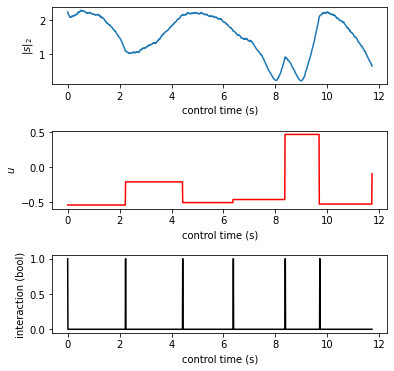

In [9]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [51]:
actor.save_weights('../saved_agent/learned_self_linear_ideal3_actor.h5')
critic.save_weights('../saved_agent/learned_self_linear_ideal3_critic.h5')

In [122]:
actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
actor.layers[2].get_weights()[0][0]

array([ 0.41994604,  0.4266636 , -0.18461692,  0.16705216, -0.25361168,
        0.34438944,  0.10308936, -0.09404683, -0.1733037 , -0.22091635,
       -0.3533952 ,  0.02600434,  0.5435894 , -0.07042186, -0.3707666 ,
        0.3166266 ], dtype=float32)

In [121]:
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
actor.layers[2].get_weights()[0][0]

array([ 0.42221597,  0.4274628 , -0.18825793,  0.16885139, -0.2542188 ,
        0.34214336,  0.10563881, -0.09488146, -0.17566861, -0.22360145,
       -0.3501546 ,  0.02824089,  0.54246134, -0.07161091, -0.37361035,
        0.31443065], dtype=float32)

In [12]:
%%time
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
critic.load_weights('../saved_agent/learned_self_linear1_extend_critic_l.h5')
lrs = learning_rate_arr(actor, size=674, u_lr=.0001, tau_lr=.001)
opt = Adam_original(lrs)

CPU times: user 4.39 s, sys: 151 ms, total: 4.54 s
Wall time: 4.97 s


In [18]:
%%time
# critic用のデータ採り
d_train = train_data(actor)

CPU times: user 3.69 s, sys: 58.2 ms, total: 3.75 s
Wall time: 4.09 s


In [30]:
%%time
critic, losses = td_learning(d_train, actor, critic, epoch=int(5000//np.sqrt(40)))

CPU times: user 2.19 s, sys: 232 ms, total: 2.43 s
Wall time: 1.81 s


In [33]:
%%time
pg = policy_gradient(actor, critic)

TypeError: gradient() missing 1 required positional argument: 'critic'

In [21]:
%%time
actor = opt.update(actor, pg/np.linalg.norm(pg))

CPU times: user 21.5 ms, sys: 3.52 ms, total: 25 ms
Wall time: 21.9 ms


In [72]:
%%time
init_state = np.array([1,2])
x = init_state
episode_time = 0
log = []
while True:
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    print(a_agent, tau)
    log.append([x, episode_time])
    reward, x = interaction(x, a_agent, tau, env, ln=0.1)
    episode_time += tau
    if episode_time >= 10.:
        log.append([x, episode_time])
        break

-0.47579882 2.0842226
-0.42807683 2.2787244
-1.5756315 4.1653085
-1.0088876 4.492806
CPU times: user 229 ms, sys: 9.46 ms, total: 238 ms
Wall time: 465 ms


In [73]:
%%time
pg = 0
# Q 関数の勾配を計算する
for i in range(1):
    s, t = log[i]
    s_prime = log[i+1][0]
    g = gradient_old(s, s_prime, actor, critic)
    g = flatten_gradient(g)
    g *= np.exp(- alpha * t)
    pg += g

CPU times: user 5.94 s, sys: 1.53 s, total: 7.47 s
Wall time: 9.16 s


In [74]:
pg

array([  46.84173584,   -2.91691399,    0.        ,    0.        ,
         -6.55131149,  -29.31933594,    2.29238129,    6.65651894,
        -25.69723892,  -41.6153183 ,    0.        ,   65.71923065,
         -4.50928116,   -6.16872597,    0.        ,  -56.7063942 ,
         93.68347168,   -5.83382797,    0.        ,    0.        ,
        -13.10262299,  -58.63867188,    4.58476257,   13.31303787,
        -51.39447784,  -83.2306366 ,    0.        ,  131.4384613 ,
         -9.01856232,  -12.33745193,    0.        , -113.41278839,
         46.84173584,   -2.91691399,    0.        ,    0.        ,
         -6.55131149,  -29.31933594,    2.29238129,    6.65651894,
        -25.69723892,  -41.6153183 ,    0.        ,   65.71923065,
         -4.50928116,   -6.16872597,    0.        ,  -56.7063942 ,
          0.        ,    0.        ,    0.        ,   20.41229057,
          0.        ,   10.91783524,    0.        ,    8.58461285,
          0.        ,   -7.05770636,    0.        ,    2.18348

In [75]:
%%time
tmp = []
for i in range(1):
    tmp.append([log[i][0], log[i][1], log[i+1][0]])
tmp = np.array(tmp)
states, ts, next_states = tmp[:,0], tmp[:,1], tmp[:,2]
pg = gradient(states, ts, next_states, actor, critic)
pg = flatten_gradient(pg)

CPU times: user 5.51 s, sys: 255 ms, total: 5.77 s
Wall time: 6.18 s


In [46]:
pg

array([-2.27420405e-01,  9.11211967e-03,  0.00000000e+00,  0.00000000e+00,
        3.26015204e-02,  1.32287651e-01, -1.60542130e-02, -2.64564678e-02,
        1.25089481e-01,  1.95075125e-01,  0.00000000e+00, -3.13965201e-01,
        1.64555907e-02,  2.53116041e-02,  0.00000000e+00,  2.62620240e-01,
       -4.54840809e-01,  1.82242393e-02,  0.00000000e+00,  0.00000000e+00,
        6.52030408e-02,  2.64575303e-01, -3.21084261e-02, -5.29129356e-02,
        2.50178963e-01,  3.90150249e-01,  0.00000000e+00, -6.27930403e-01,
        3.29111814e-02,  5.06232083e-02,  0.00000000e+00,  5.25240481e-01,
       -2.27420405e-01,  9.11211967e-03,  0.00000000e+00,  0.00000000e+00,
        3.26015204e-02,  1.32287651e-01, -1.60542130e-02, -2.64564678e-02,
        1.25089481e-01,  1.95075125e-01, -0.00000000e+00, -3.13965201e-01,
        1.64555907e-02,  2.53116041e-02,  0.00000000e+00,  2.62620240e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.77820250e-02,
        0.00000000e+00,  

In [27]:
%%time
g = gradient(s, s_prime, actor, critic)

CPU times: user 1.65 s, sys: 42.9 ms, total: 1.69 s
Wall time: 1.79 s


In [28]:
%%time
g = flatten_gradient(g)

CPU times: user 286 µs, sys: 17 µs, total: 303 µs
Wall time: 356 µs


In [11]:
sr = '''
loss of critic is 0.23791567981243134, value_fuction V(s) = -4.583669602475538
|g| = 57.169726506056165
2-step
loss of critic is 0.14756543934345245, value_fuction V(s) = -4.072578407908122
|g| = 59.7986426492836
3-step
loss of critic is 0.36680868268013, value_fuction V(s) = -4.632472616542504
|g| = 31.15367754130089
4-step
loss of critic is 0.47914400696754456, value_fuction V(s) = -4.317590537333074
|g| = 45.39435892028647
5-step
loss of critic is 0.7256523966789246, value_fuction V(s) = -3.796758183182961
|g| = 150.14212206814597
6-step
loss of critic is 0.8029432892799377, value_fuction V(s) = -4.252649723292302
|g| = 177.55347263404127
7-step
loss of critic is 1.1220664978027344, value_fuction V(s) = -5.360345773809712
|g| = 201.1570649538734
8-step
loss of critic is 2.0594136714935303, value_fuction V(s) = -10.552442840438998
|g| = 1004.1482815972828
9-step
loss of critic is 1.3158717155456543, value_fuction V(s) = -5.640600826386198
|g| = 1720.665259920988
10-step
loss of critic is 0.8560346961021423, value_fuction V(s) = -6.027673472512478
|g| = 478.7759481276946
11-step
loss of critic is 1.1935423612594604, value_fuction V(s) = -7.122041421438693
|g| = 541.2904082058352
12-step
loss of critic is 0.9228097796440125, value_fuction V(s) = -27.120980365798097
|g| = 1261.3506741711271
13-step
loss of critic is 1.1632826328277588, value_fuction V(s) = -30.080927722897044
|g| = 3856.8401814045233
14-step
loss of critic is 1.066743016242981, value_fuction V(s) = -29.72686767095749
|g| = 2683.2658432208964
15-step
loss of critic is 0.9635929465293884, value_fuction V(s) = -16.552797647307255
|g| = 3362.2659978833854
16-step
loss of critic is 0.7066486477851868, value_fuction V(s) = -17.86216209485191
|g| = 2308.9973875646
17-step
loss of critic is 0.7857291102409363, value_fuction V(s) = -16.79105166960125
|g| = 1888.444661408995
18-step
loss of critic is 0.7392614483833313, value_fuction V(s) = -26.121082909563874
|g| = 2693.3317557637483
19-step
loss of critic is 0.9426022171974182, value_fuction V(s) = -24.232775700123632
|g| = 4504.5754133366145
20-step
loss of critic is 0.7399324774742126, value_fuction V(s) = -12.51468371562564
|g| = 7229.97985787979
21-step
loss of critic is 0.642276406288147, value_fuction V(s) = -7.370613431271828
|g| = 5340.656380898319
22-step
loss of critic is 0.8370692133903503, value_fuction V(s) = -5.861007713862323
|g| = 1370.2119797687112
23-step
loss of critic is 0.8920913934707642, value_fuction V(s) = -5.221332349709233
|g| = 1112.436712404174
24-step
loss of critic is 0.6703740954399109, value_fuction V(s) = -7.380802057346238
|g| = 529.2230987582658
25-step
loss of critic is 0.7185093760490417, value_fuction V(s) = -7.368969342575125
|g| = 3241.2682661128274
26-step
loss of critic is 0.50247722864151, value_fuction V(s) = -3.601938769591252
|g| = 3804.347701580047
27-step
loss of critic is 0.4726845622062683, value_fuction V(s) = -4.6196762412357595
|g| = 835.0244568676426
28-step
loss of critic is 0.4371712803840637, value_fuction V(s) = -4.532935434777062
|g| = 1095.6904819689348
29-step
loss of critic is 0.7453640699386597, value_fuction V(s) = -4.716693309127797
|g| = 1769.1369491386265
30-step
loss of critic is 0.4771822690963745, value_fuction V(s) = -5.82593907158545
|g| = 1287.0847065379346
31-step
loss of critic is 0.5391621589660645, value_fuction V(s) = -5.352531883429533
|g| = 1241.0912244103033
32-step
loss of critic is 0.45852532982826233, value_fuction V(s) = -9.076342605384593
|g| = 8106.535236927013
33-step
loss of critic is 0.5140160322189331, value_fuction V(s) = -3.9290944318888186
|g| = 5139.64984545737
34-step
loss of critic is 0.6324589848518372, value_fuction V(s) = -4.681491700160531
|g| = 1365.346619304791
35-step
loss of critic is 0.5274073481559753, value_fuction V(s) = -3.7918579971078565
|g| = 1127.190175817918
36-step
loss of critic is 0.5383074283599854, value_fuction V(s) = -4.755662829213665
|g| = 1838.0808559503469
37-step
loss of critic is 0.38343629240989685, value_fuction V(s) = -12.266449644041696
|g| = 635.5168548283908
38-step
loss of critic is 0.5392838716506958, value_fuction V(s) = -16.304715114875854
|g| = 747.7568776376426
39-step
loss of critic is 0.6143695712089539, value_fuction V(s) = -4.316363190155809
|g| = 1052.2826947219694
40-step
loss of critic is 0.4474676847457886, value_fuction V(s) = -5.391312009431047
|g| = 2486.594009680489
41-step
loss of critic is 0.6413789987564087, value_fuction V(s) = -4.607295174216973
|g| = 4125.390591794792
42-step
loss of critic is 0.4030541479587555, value_fuction V(s) = -4.892975541453275
|g| = 2292.826145147753
43-step
loss of critic is 0.4695047438144684, value_fuction V(s) = -4.791583411798834
|g| = 1941.5174498165675
44-step
loss of critic is 0.35379457473754883, value_fuction V(s) = -4.471537151640796
|g| = 1724.1209440561413
45-step
loss of critic is 0.5866801142692566, value_fuction V(s) = -4.395129714936333
|g| = 1151.2464281264204
46-step
loss of critic is 0.2544679343700409, value_fuction V(s) = -4.459515829869131
|g| = 1281.8716921152052
47-step
loss of critic is 0.39389246702194214, value_fuction V(s) = -4.181282776636654
|g| = 2564.112950244772
48-step
loss of critic is 0.34891030192375183, value_fuction V(s) = -4.31167376371156
|g| = 1820.4639125686429
49-step
loss of critic is 0.27356454730033875, value_fuction V(s) = -9.94287915631066
|g| = 1346.8577264692422
50-step
loss of critic is 0.2319067418575287, value_fuction V(s) = -12.053110488591729
|g| = 756.2206162134044
51-step
loss of critic is 0.21887539327144623, value_fuction V(s) = -7.4610358866638355
|g| = 6581.067667300754
52-step
loss of critic is 0.1756947636604309, value_fuction V(s) = -7.688581927818593
|g| = 1534.1306414055189
53-step
loss of critic is 0.2942005395889282, value_fuction V(s) = -8.500302339900003
|g| = 489.82653806174847
54-step
loss of critic is 0.28797516226768494, value_fuction V(s) = -3.857543224248553
|g| = 2975.9060536035445
55-step
loss of critic is 0.4546959400177002, value_fuction V(s) = -5.925152438020806
|g| = 1811.8728307319088
56-step
loss of critic is 0.35327741503715515, value_fuction V(s) = -3.7392742966425243
|g| = 452.1072414744362
57-step
loss of critic is 0.5254454612731934, value_fuction V(s) = -3.5222246720288846
|g| = 320.4044789441325
58-step
loss of critic is 0.5032379031181335, value_fuction V(s) = -3.429607305369734
|g| = 630.3257114971263
59-step
loss of critic is 0.4609425663948059, value_fuction V(s) = -3.480262979741706
|g| = 414.8157375296055
60-step
loss of critic is 0.43220770359039307, value_fuction V(s) = -3.3234551392446194
|g| = 414.83869630920407
61-step
loss of critic is 0.5731462836265564, value_fuction V(s) = -4.109788030475544
|g| = 912.7911526490743
62-step
loss of critic is 0.524193286895752, value_fuction V(s) = -2.5336656526894896
|g| = 965.9744702584192
63-step
loss of critic is 0.42883554100990295, value_fuction V(s) = -3.656953945376718
|g| = 795.2771939591281
64-step
loss of critic is 0.463092565536499, value_fuction V(s) = -3.333216259677033
|g| = 302.48699393043216
65-step
loss of critic is 0.5324851274490356, value_fuction V(s) = -3.350513224492641
|g| = 362.241219382329
66-step
loss of critic is 0.5186604261398315, value_fuction V(s) = -3.69288148871531
|g| = 302.7741625773069
67-step
loss of critic is 0.4551144540309906, value_fuction V(s) = -3.9729566421854163
|g| = 384.6740342097964
68-step
loss of critic is 0.6368967890739441, value_fuction V(s) = -3.318806244848691
|g| = 181.54608074295865
69-step
loss of critic is 0.5683951377868652, value_fuction V(s) = -3.310171423216806
|g| = 382.3129990731224
70-step
loss of critic is 0.580841600894928, value_fuction V(s) = -7.844185250531456
|g| = 453.90470534227734
71-step
loss of critic is 0.6451497077941895, value_fuction V(s) = -3.3060573503179396
|g| = 1568.1474378740254
72-step
loss of critic is 0.5026673674583435, value_fuction V(s) = -3.285253367429398
|g| = 1947.2366425143719
73-step
loss of critic is 0.5143139362335205, value_fuction V(s) = -3.2482443125371887
|g| = 767.2921033624216
74-step
loss of critic is 0.4092102348804474, value_fuction V(s) = -2.944407108161173
|g| = 304.35769963816654
75-step
loss of critic is 0.43056249618530273, value_fuction V(s) = -3.0875558157400125
|g| = 238.31594539206822
76-step
loss of critic is 0.3793679177761078, value_fuction V(s) = -3.9834627681784207
|g| = 679.5720706401713
77-step
loss of critic is 0.538124144077301, value_fuction V(s) = -3.8407133413028642
|g| = 1713.8418565925692
78-step
loss of critic is 0.2990523874759674, value_fuction V(s) = -3.008521432277779
|g| = 222.53382301239589
79-step
loss of critic is 0.429521769285202, value_fuction V(s) = -4.523131451845295
|g| = 531.4101588111638
80-step
loss of critic is 0.356693297624588, value_fuction V(s) = -4.632073995272921
|g| = 922.0492006392983
81-step
loss of critic is 0.37973737716674805, value_fuction V(s) = -3.0893682261143605
|g| = 549.4056911856035
82-step
loss of critic is 0.36416107416152954, value_fuction V(s) = -2.9725726718672667
|g| = 398.03575375649405
83-step
loss of critic is 0.3728991150856018, value_fuction V(s) = -2.8933968053902737
|g| = 497.16535148228553
84-step
loss of critic is 0.34495800733566284, value_fuction V(s) = -3.5834699457556054
|g| = 556.9010345810038
85-step
loss of critic is 0.34329482913017273, value_fuction V(s) = -3.3443484369322527
|g| = 755.1046320497018
86-step
loss of critic is 0.42100369930267334, value_fuction V(s) = -3.5685071261009895
|g| = 689.4776897744141
87-step
loss of critic is 0.4448075294494629, value_fuction V(s) = -3.7030824636251656
|g| = 1133.0828499967204
88-step
loss of critic is 0.5246404409408569, value_fuction V(s) = -3.1353709979547886
|g| = 1110.5731164206547
89-step
loss of critic is 0.35118281841278076, value_fuction V(s) = -3.035993905794113
|g| = 1313.139775734696
90-step
loss of critic is 0.35209354758262634, value_fuction V(s) = -3.0620176021224514
|g| = 1012.6478010724957
91-step
loss of critic is 0.42084774374961853, value_fuction V(s) = -3.2457392509216065
|g| = 919.3798820257334
92-step
loss of critic is 0.48252928256988525, value_fuction V(s) = -3.010139178659653
|g| = 1659.912445263915
93-step
loss of critic is 0.3815731406211853, value_fuction V(s) = -3.1613895163667243
|g| = 841.8723048232167
94-step
loss of critic is 0.4825012683868408, value_fuction V(s) = -2.9472439175964484
|g| = 1139.4646459800397
95-step
loss of critic is 0.5311598777770996, value_fuction V(s) = -6.157177301216391
|g| = 410.9758510935679
96-step
loss of critic is 0.4140812158584595, value_fuction V(s) = -3.8398893533029645
|g| = 722.4861266416342
97-step
loss of critic is 0.3444906175136566, value_fuction V(s) = -2.7099033495746774
|g| = 1097.7175152460543
98-step
loss of critic is 0.4638053774833679, value_fuction V(s) = -2.919200717842318
|g| = 262.837563613053
99-step
loss of critic is 0.46515780687332153, value_fuction V(s) = -3.9463861255099455
|g| = 307.72615663652607

'''

In [52]:
l = []
rs = []
for s in sr:
    if s != '\n':
        l.append(s)
    else:
        if len(l) > 30:
            #print(''.join([k for k in l[-19:] if k != '=']), len(l))
            rs.append(float(''.join([k for k in l[-19:] if k != '='])))
        l = []

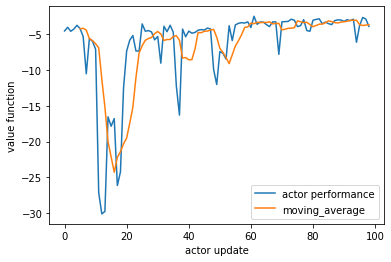

In [56]:
#rs = rs[15:]
m = 5
plt.plot(rs, label='actor performance')
plt.plot(range(m, len(rs)), moving_average(rs,m), label='moving_average')
plt.xlabel('actor update')
plt.ylabel('value function')
plt.legend()